In [1]:
! nvidia-smi

Thu Mar  2 17:00:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-02 17:00:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-02 17:00:14 (50.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import (create_tensorboard_callback,
                             plot_loss_curves,
                             unzip_data,
                             compare_historys,
                             walk_through_dir)

In [4]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-03-02 17:00:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   217MB/s    in 6.6s    

2023-03-02 17:00:32 (236 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 im

In [8]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tqdm.notebook import tqdm
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

In [9]:
IMG_SIZE = (224, 224)

In [10]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               batch_size=32,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                              batch_size=32,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE,
                                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
checkpoints_path = "checkpoints/"
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoints_path,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 save_weights_only=True)

In [12]:
data_augmentation_block = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # for models like resnet
], name="data_augmentation")

In [13]:
base = tf.keras.applications.EfficientNetB0(include_top=False)
base.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="inputs")
x = data_augmentation_block(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="outputs")(x)
model = tf.keras.models.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

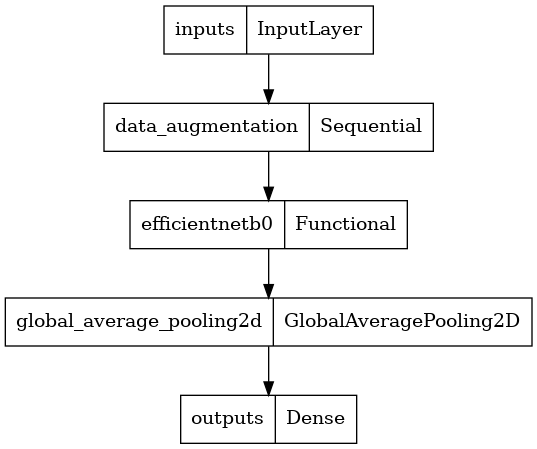

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
history = model.fit(train_data_all_10_percent, epochs=5, validation_data=test_data_all_10_percent)

Epoch 1/5
237/237 [==============================] - 173s 662ms/step - loss: 3.3813 - accuracy: 0.2709 - val_loss: 2.3138 - val_accuracy: 0.4789
Epoch 2/5
237/237 [==============================] - 145s 610ms/step - loss: 2.2032 - accuracy: 0.5057 - val_loss: 1.8746 - val_accuracy: 0.5394
Epoch 3/5
237/237 [==============================] - 138s 582ms/step - loss: 1.8309 - accuracy: 0.5632 - val_loss: 1.7123 - val_accuracy: 0.5644
Epoch 4/5
237/237 [==============================] - 131s 550ms/step - loss: 1.6088 - accuracy: 0.6094 - val_loss: 1.6300 - val_accuracy: 0.5786
Epoch 5/5
237/237 [==============================] - 130s 548ms/step - loss: 1.4638 - accuracy: 0.6422 - val_loss: 1.5958 - val_accuracy: 0.5768


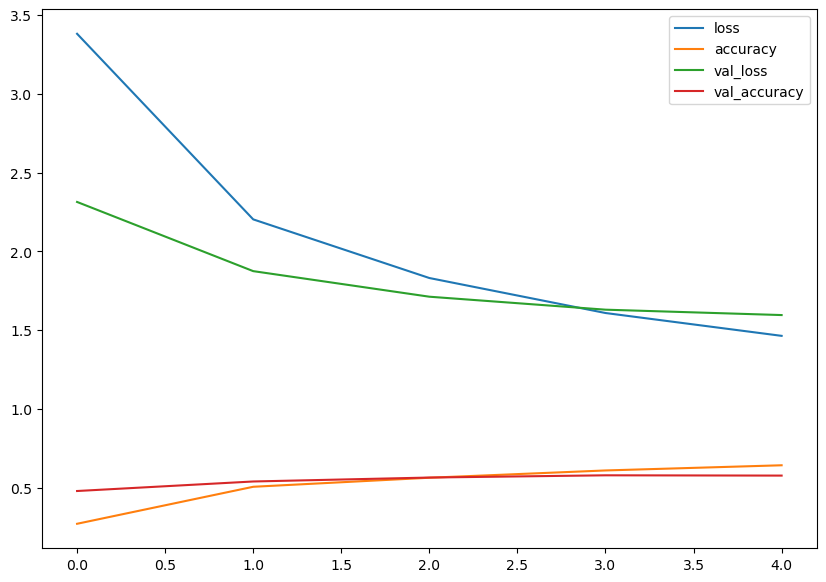

In [17]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.show()

# Fine tuning EfficientNetB0 architecture
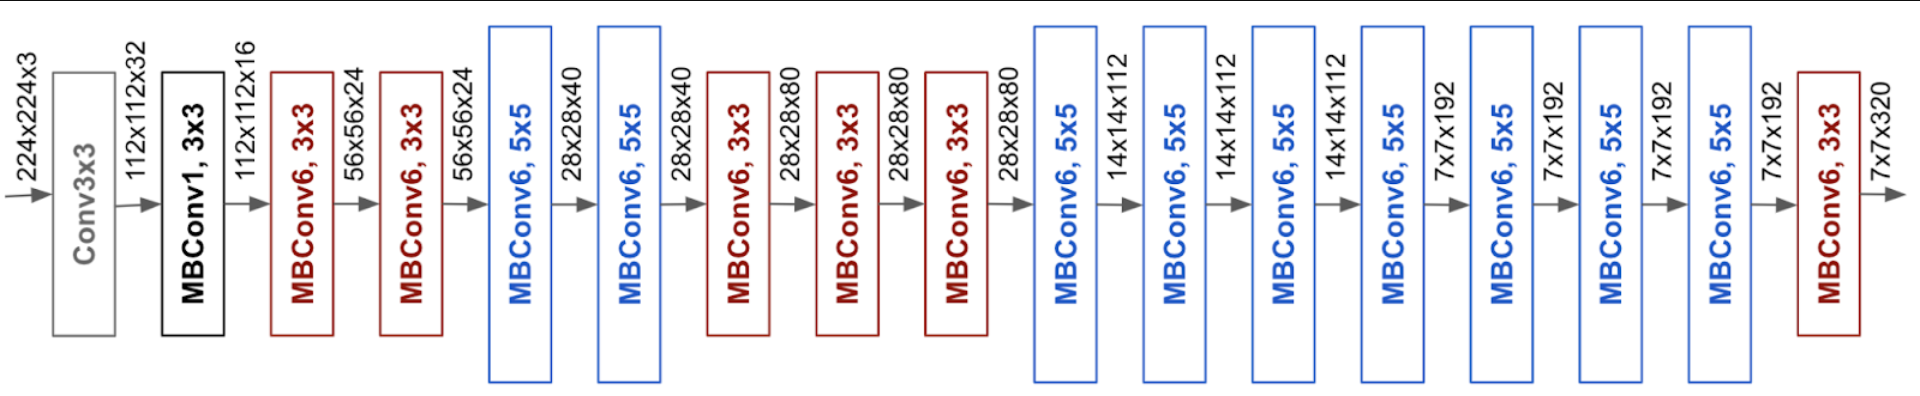

In [18]:
# unfreeze all the layers of base
base.trainable = True
# freeze all layers except top/last 5
for layer in base.layers[:-5]:
    layer.trainable = False

In [19]:
# recompile the model (lower the learning rate, it's best practice to do so while fine tuning)
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [20]:
# fine tuning for 5 more epochs
history_fine_tuning = model.fit(train_data_all_10_percent, epochs=10, validation_data=test_data_all_10_percent, initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 156s 612ms/step - loss: 1.2095 - accuracy: 0.6869 - val_loss: 1.5127 - val_accuracy: 0.5930
Epoch 6/10
237/237 [==============================] - 122s 513ms/step - loss: 1.0857 - accuracy: 0.7094 - val_loss: 1.5107 - val_accuracy: 0.5943
Epoch 7/10
237/237 [==============================] - 121s 507ms/step - loss: 1.0231 - accuracy: 0.7266 - val_loss: 1.4898 - val_accuracy: 0.6001
Epoch 8/10
237/237 [==============================] - 119s 502ms/step - loss: 0.9499 - accuracy: 0.7426 - val_loss: 1.4935 - val_accuracy: 0.6025
Epoch 9/10
237/237 [==============================] - 120s 504ms/step - loss: 0.9077 - accuracy: 0.7563 - val_loss: 1.4813 - val_accuracy: 0.6046
Epoch 10/10
237/237 [==============================] - 116s 489ms/step - loss: 0.8355 - accuracy: 0.7744 - val_loss: 1.4926 - val_accuracy: 0.6042


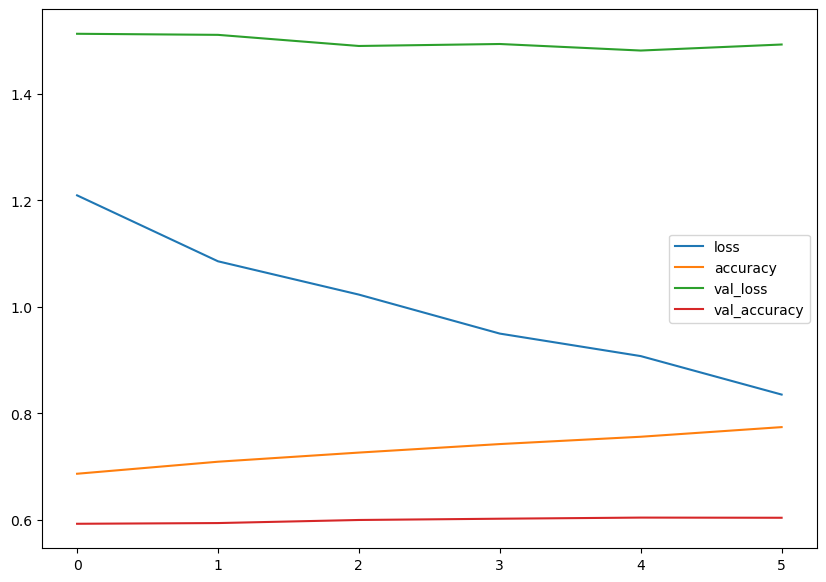

In [21]:
pd.DataFrame(history_fine_tuning.history).plot(figsize=(10,7))
plt.show()

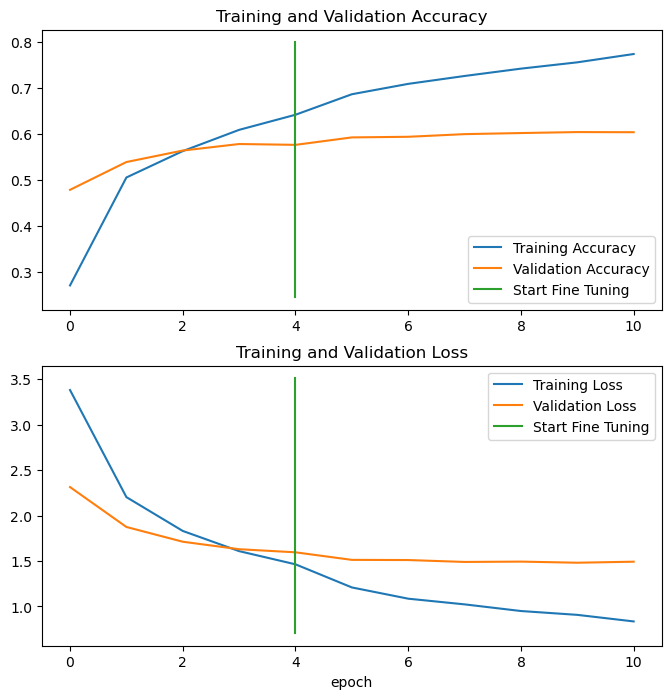

In [22]:
compare_historys(original_history=history,
                new_history=history_fine_tuning,
                initial_epochs=5)

In [23]:
model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 59s 74ms/step - loss: 1.4926 - accuracy: 0.6042


[1.492592453956604, 0.6042376160621643]

## Making predictions

In [24]:
pred_probs = model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 59s 72ms/step


In [25]:
len(pred_probs)

25250

In [26]:
pred_probs.shape

(25250, 101)

In [27]:
pred_probs[0]

array([3.84894639e-01, 5.35504310e-04, 5.62954396e-02, 3.10806939e-07,
       8.24605559e-06, 1.44889259e-06, 1.03667735e-04, 4.13339603e-06,
       3.15301418e-02, 1.13779890e-04, 8.23201844e-07, 3.30021112e-06,
       2.03258474e-03, 3.35628073e-07, 1.47561228e-03, 1.22763810e-03,
       2.37480181e-05, 1.23211497e-03, 4.19073924e-03, 2.03708769e-05,
       2.17549806e-03, 8.90355386e-06, 7.27329316e-05, 4.83567746e-05,
       7.14926573e-04, 2.79408996e-03, 3.69952613e-04, 2.04654352e-05,
       2.24445179e-01, 1.38582604e-03, 3.86020702e-06, 1.54101662e-03,
       6.05296751e-04, 6.66045480e-07, 5.33847371e-03, 1.79798667e-06,
       7.78069298e-05, 1.50879705e-03, 4.93364483e-02, 3.99134660e-05,
       2.27854252e-04, 5.76894497e-04, 1.90031060e-04, 3.17664853e-05,
       1.48274383e-04, 8.27665735e-06, 8.48494412e-04, 9.14923949e-05,
       2.12549139e-06, 5.09690344e-02, 1.24182479e-04, 7.88769394e-05,
       3.12576666e-02, 2.38495506e-02, 1.27666517e-05, 8.13939329e-03,
      

In [28]:
pred_classes = pred_probs.argmax(axis=1)

In [29]:
pred_classes[:10]

array([ 0,  0,  0,  0,  8, 78, 29,  0,  0,  0])

In [30]:
test_data_all_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [31]:
y_labels = []
for image, labels in tqdm(test_data_all_10_percent.unbatch()):
    y_labels.append(labels.numpy().argmax()) # taking argmax, as labels are one hot encoded

0it [00:00, ?it/s]

In [32]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
accuracy_score(y_labels, pred_classes)

0.6042376237623762

In [34]:
cm = confusion_matrix(y_labels, pred_classes)

In [35]:
plot_confusion_matrix(cm, class_names=test_data_all_10_percent.class_names, figsize=(100,100), cmap=plt.cm.Blues)
plt.show()

In [36]:
metrics = classification_report(y_labels, pred_classes, output_dict=True)

In [37]:
class_f1_scores = {}
for k, v in metrics.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[test_data_all_10_percent.class_names[int(k)]] = v["f1-score"]

In [38]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33    edamame  0.960938
63   macarons  0.872807
69    oysters  0.867470
32  dumplings  0.842742
75        pho  0.841300
..        ...       ...
77  pork_chop  0.308333
66     nachos  0.305195
39  foie_gras  0.296089
0   apple_pie  0.282143
93      steak  0.277916

[101 rows x 2 columns]

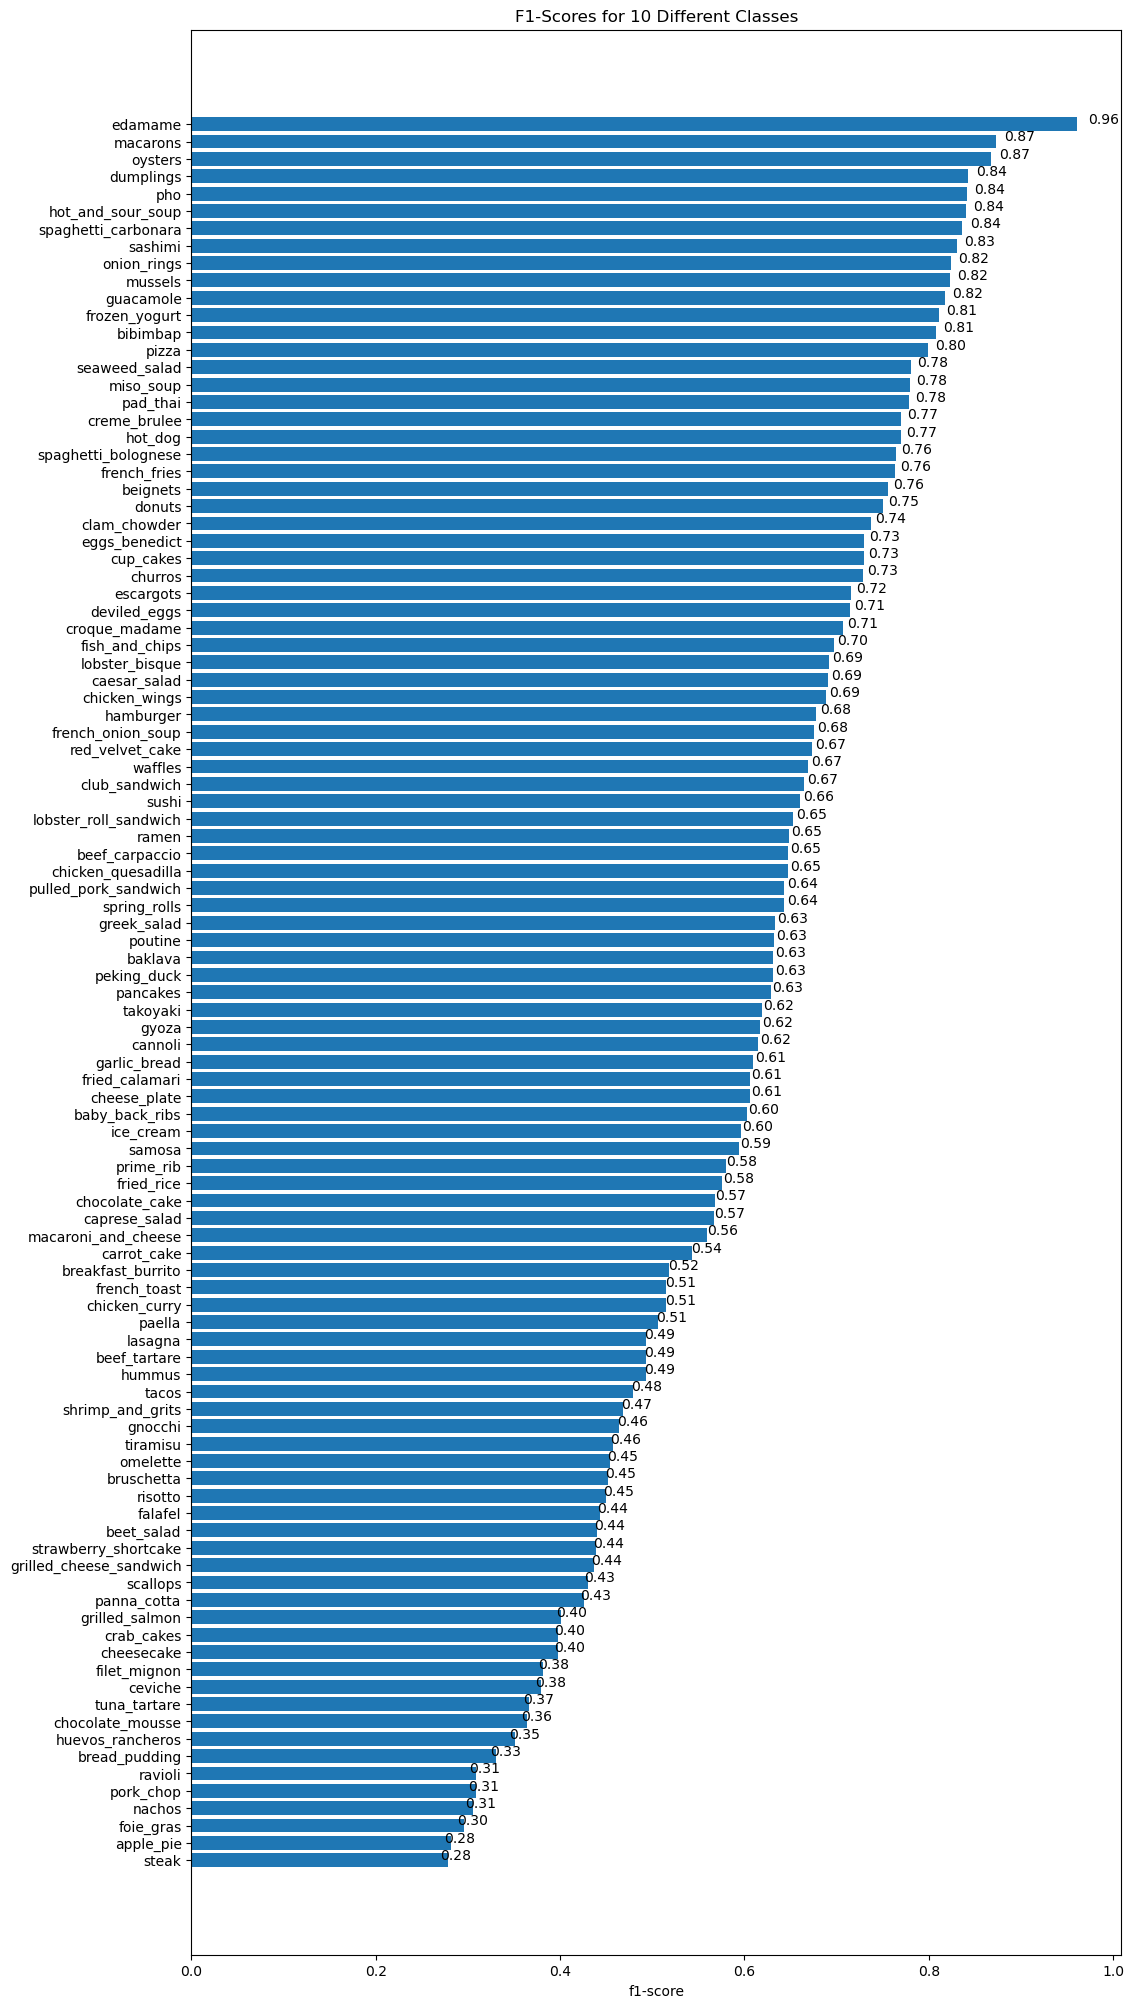

In [39]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [40]:
def load_and_prep_image(filename, image_shape=224, scale=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [image_shape, image_shape])
    if (scale):
        return img / 255.
    return img

1/1 [==============================] - 0s 32ms/step


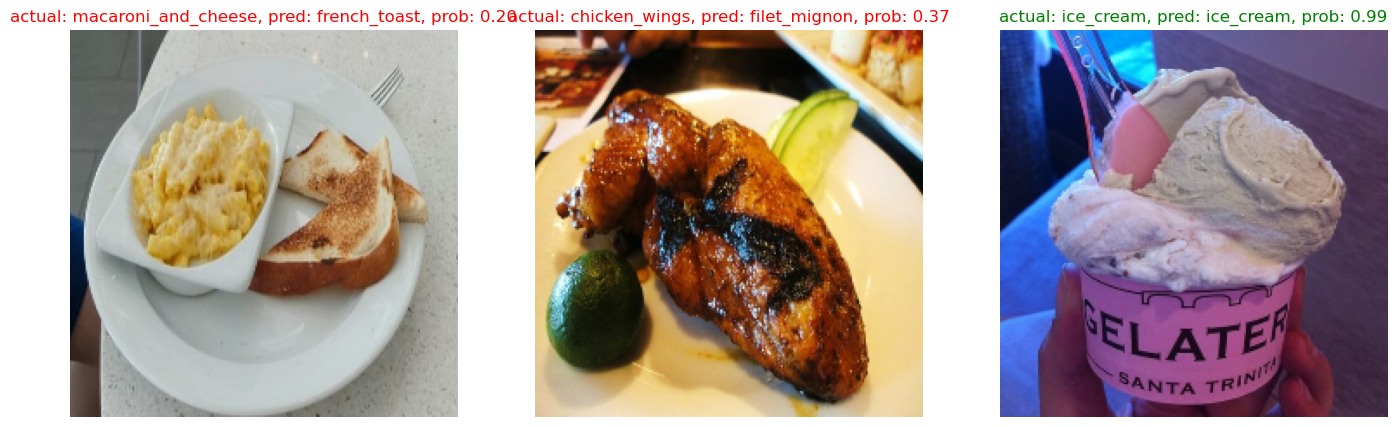

In [41]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(test_data_all_10_percent.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = test_data_all_10_percent.class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [43]:
filepaths = []
for filepath in test_data_all_10_percent.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [45]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [test_data_all_10_percent.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data_all_10_percent.class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.384895        apple_pie        apple_pie  
1   0.900757        apple_pie        apple_pie  
2   0.753030        apple_pie        apple_pie  
3   0.252223        apple_pie        apple_pie  
4   0.552696        apple_pie    bread_pudding

In [46]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.384895        apple_pie        apple_pie          True  
1   0.900757        apple_pie        apple_pie          True  
2   0.753030        apple_pie        apple_pie          True  
3   0.252223        apple_pie        apple_pie          True  
4   0.552696        apple_pie    bread_pudding         False

In [47]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
14630  b'101_food_classes_10_percent/test/ice_cream/3...      58      78   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
24479  b'101_food_classes_10_percent/test/takoyaki/68...      97      78   
14255  b'101_food_classes_10_percent/test/hummus/1071...      57      49   
733    b'101_food_classes_10_percent/test/baklava/763...       2      12   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
19430  b'101_food_classes_10_percent/test/pork_chop/3...      77       1   
9110   b'101_food_classes_10_percent/test/falafel/241...      36      31   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   

       pred_conf      y_true_classname         y_pred_classname  pred_correct  
23797   0.999235                 sushi                  sashimi         False  
191     0.998764             apple_pie                   donuts         False  
18001   0.998610              pancakes                 omelette         False  
11642   0.997437          garlic_bread               bruschetta         False  
10847   0.997289        fried_calamari              onion_rings         False  
9326    0.996380          filet_mignon                prime_rib         False  
16271   0.996369               mussels                  oysters         False  
17855   0.996294                paella                  mussels         False  
14691   0.994878             ice_cream                prime_rib         False  
14630   0.994856             ice_cream                  poutine         False  
23631   0.994150  strawberry_shortcake          red_velvet_cake         False  
24479   0.994046              takoyaki                  poutine         False  
14255   0.993405                hummus  grilled_cheese_sandwich         False  
733     0.993393               baklava                  cannoli         False  
15142   0.992604        lobster_bisque                miso_soup         False  
7295    0.992582             cup_cakes                   donuts         False  
10854   0.992439        fried_calamari              onion_rings         False  
19430   0.992011             pork_chop           baby_back_ribs         False  
9110    0.989724               falafel                   donuts         False  
13144   0.989603                 gyoza             spring_rolls         False

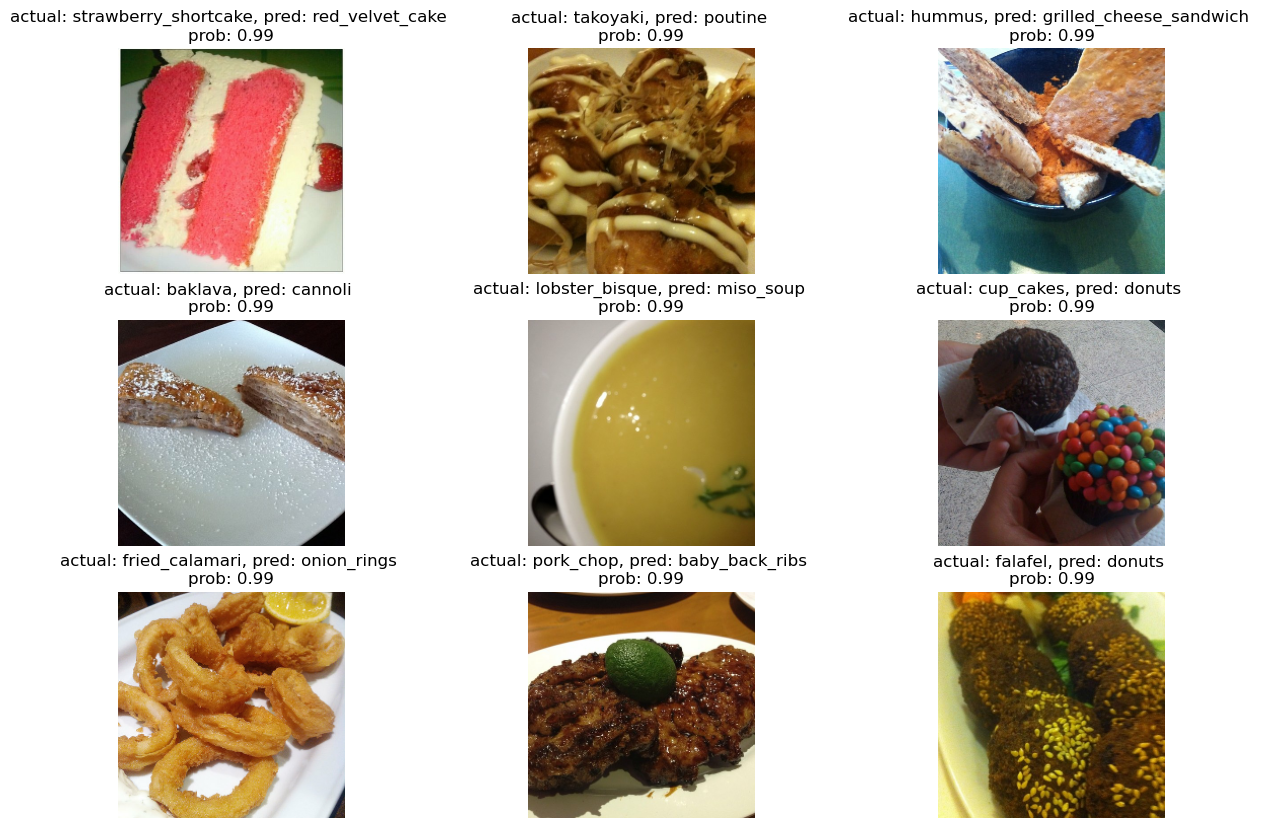

In [48]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)